# Check the data correctness

Comparison and analyses of two different datasets with the same features: TidyTuesday dataset and USDA ones.
They should contain the same information inside the same datapoints, but it turned out the values were different. <br>
This notebook aims to understand which dataset has reasonable values that could be considered reliable starting from the knowledge and feature understanding we found in literature.

In [1]:
from pathlib import Path
import sys
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#pd.__version__

In [5]:
XSMALL_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=XSMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=XSMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=XSMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', None, 'display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

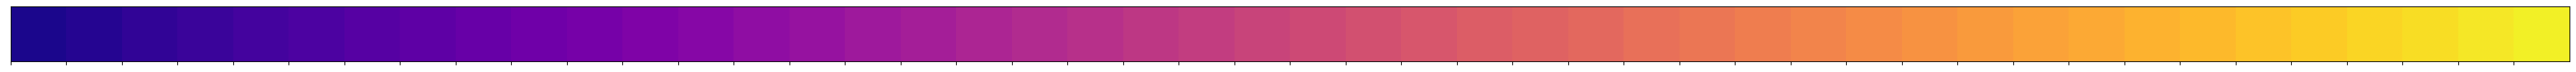

In [6]:
custom_states = sns.color_palette("plasma", 46) #as the number of states
sns.palplot(custom_states)

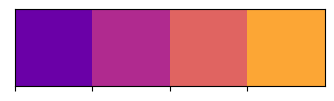

In [7]:
color_quarters = sns.color_palette("plasma", 4)
sns.palplot(color_quarters)

# TidyTuesday dataset of bee colony loss and stressors

In [11]:
root_path = Path(os.getcwd())
start_path = str(root_path.parent.parent)
df_colony = pd.read_csv(start_path + "/code/DataConsistency/colony.csv")
df_stressor = pd.read_csv(start_path + "/code/DataConsistency/stressor.csv")

In [12]:
df_colony.head()

,year,months,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct
0,2015,January-March,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0
1,2015,January-March,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0
2,2015,January-March,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0
3,2015,January-March,California,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0
4,2015,January-March,Colorado,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0


In [13]:
#display(df_stressor.to_string())
#print(df_stressor.to_markdown())
df_stressor.head()

,year,months,state,stressor,stress_pct
0,2015,January-March,Alabama,Varroa mites,10.0
1,2015,January-March,Alabama,Other pests/parasites,5.4
2,2015,January-March,Alabama,Disesases,NaN
3,2015,January-March,Alabama,Pesticides,2.2
4,2015,January-March,Alabama,Other,9.1


In [14]:
#map the trimesters into Q1, Q2, Q3, Q4 to guarantee the alphabetical order while grouping
map_quarters = {
    "January-March": "Q1",
    "April-June": "Q2",
    "July-September": "Q3",
    "October-December": "Q4"
}
df_colony['months'] = df_colony['months'].map(map_quarters)
df_stressor['months'] = df_stressor['months'].map(map_quarters)
df_new_stressor = pd.pivot_table(df_stressor, values = 'stress_pct', index = ['year', 'months', 'state'], columns = ['stressor'], sort=False) #fill_value = 0
df_new_stressor.head()

stressor                Disesases  Other  Other pests/parasites  Pesticides  \
year months state                                                             
2015 Q1     Alabama           NaN    9.1                    5.4         2.2   
            Arizona           0.1    1.8                   20.5         NaN   
            Arkansas          1.5    1.0                   11.4         3.4   
            California        3.0    6.5                    7.2         7.5   
            Colorado          1.8    2.6                    0.9         0.6   

stressor                Unknown  Varroa mites  
year months state                              
2015 Q1     Alabama         9.4          10.0  
            Arizona         3.1          26.9  
            Arkansas        1.0          17.6  
            California      2.8          24.7  
            Colorado        5.9          14.6

In [15]:
#stressors = df_new_stressor.columns.tolist()

#create MultiIndex in colony dataset
df_colony = df_colony.set_index(['year', 'months', 'state'])
df_colony.head()
#merge the two datasets
dfs = [df_colony, df_new_stressor]
df_years = pd.concat(dfs, axis=1)

#df_years.index.names
#df_years.index.values
#df_years.reset_index()

#add name 'stressor' to stressor columns
#stressor_names = list(map(lambda x: 'Stressor_' + x,list(df_years.columns)[7:]))
#df_years.columns = df_years.columns.tolist()[:7] + stressor_names

df_years.head()

colony_n  colony_max  colony_lost  colony_lost_pct  \
year months state                                                             
2015 Q1     Alabama        7000.0      7000.0       1800.0             26.0   
            Arizona       35000.0     35000.0       4600.0             13.0   
            Arkansas      13000.0     14000.0       1500.0             11.0   
            California  1440000.0   1690000.0     255000.0             15.0   
            Colorado       3500.0     12500.0       1500.0             12.0   

                        colony_added  colony_reno  colony_reno_pct  Disesases  \
year months state                                                               
2015 Q1     Alabama           2800.0        250.0              4.0        NaN   
            Arizona           3400.0       2100.0              6.0        0.1   
            Arkansas          1200.0         90.0              1.0        1.5   
            California      250000.0     124000.0              7.0        3.0   
            Colorado           200.0        140.0              1.0        1.8   

                        Other  Other pests/parasites  Pesticides  Unknown  \
year months state                                                           
2015 Q1     Alabama       9.1                    5.4         2.2      9.4   
            Arizona       1.8                   20.5         NaN      3.1   
            Arkansas      1.0                   11.4         3.4      1.0   
            California    6.5                    7.2         7.5      2.8   
            Colorado      2.6                    0.9         0.6      5.9   

                        Varroa mites  
year months state                     
2015 Q1     Alabama             10.0  
            Arizona             26.9  
            Arkansas            17.6  
            California          24.7  
            Colorado            14.6

In [16]:
#df is the merged dataset without the MultiIndex
df = df_years.reset_index()
df.head()

,year,months,state,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
0,2015,Q1,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0,NaN,9.1,5.4,2.2,9.4,10.0
1,2015,Q1,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0,0.1,1.8,20.5,NaN,3.1,26.9
2,2015,Q1,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0,1.5,1.0,11.4,3.4,1.0,17.6
3,2015,Q1,California,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0,3.0,6.5,7.2,7.5,2.8,24.7
4,2015,Q1,Colorado,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0,1.8,2.6,0.9,0.6,5.9,14.6


In [17]:
#check the number of states
print(len(df.state.unique())) #46 states + "United States"
print(df.shape) #(1380, 16)

47
(1410, 16)


In [18]:
#Extract United States dataset
#df_US = df.loc[(slice(None), slice(None), 'United States'),:]
df_US = df[df.state == 'United States']
df_US.drop(columns = ["state"], inplace=True)
df_years.drop(index = "United States", level=2, inplace=True)
df = df[df.state != 'United States']
df_US.head()
#df.index.tolist()

,year,months,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Disesases,Other,Other pests/parasites,Pesticides,Unknown,Varroa mites
46,2015,Q1,2824610.0,NaN,500020.0,18.0,546980.0,270530.0,10.0,3.1,6.9,8.6,7.4,4.3,25.2
93,2015,Q2,2849500.0,NaN,352860.0,12.0,661860.0,692850.0,24.0,4.9,11.6,19.5,16.6,3.5,43.4
140,2015,Q3,3132880.0,NaN,457100.0,15.0,172990.0,303070.0,10.0,8.0,8.8,17.6,15.2,4.8,41.2
187,2015,Q4,2874760.0,NaN,412380.0,14.0,117150.0,158790.0,6.0,5.2,7.3,11.4,9.5,6.9,37.0
234,2016,Q1,2594590.0,NaN,428800.0,17.0,378160.0,158050.0,6.0,6.2,7.0,12.6,10.5,5.4,34.3


## Check the understanding of features and their interpretation

From literature: <br>
- **Added colonies**: A new or replacement, surviving colony that was either created or purchased whole by an operation.
- **Colony**: A hive containing a queen honey bee and attendant worker bees and/or drone bees.
- **Lost colony**: A completely failed colony, loss of most workers, and possibly the queen. Colony is no longer viable. Sometimes referred to as a dead out.

- **Maximum colonies**: Refers to the sum of colonies in a state on the first of the quarter plus all those moved into the state during that period. Maximum colonies is considered the base number from which a data user can do further analysis. It does not include the colonies that were added, lost, or renovated in the state. Colonies are counted in every state they were in during the quarter; therefore, a national level maximum number of colonies cannot be calculated due to duplication.
- **Percent lost**: The state-level percentage of colonies lost is the number of colonies lost in that state divided by the maximum colonies for that state. The national level percentage of colonies lost is the total number of all colonies lost in the United States divided by the number of colonies on the first of the quarter.
- **Percent renovated**: The state-level percentage of colonies renovated is the number of colonies renovated in that state divided by the maximum colonies for that state. The national level percentage of colonies renovated is the total number of all colonies renovated in the United States divided by the number of colonies on the first of the quarter.
- **Renovated colony**: An existing colony that was requeened or received a nuc or package.
- **Stressors**: State level colony health stressors for operations with five or more colonies are the percent of the maximum colonies reported to be affected, by quarter. The national level colony stressors is the summed number for the United States divided by the number of colonies on the first of the quarter.

## US Data

In [19]:
df_US2 = df_US[["year", "months", "colony_n", "colony_lost", "colony_added", "colony_reno"]]
df_US2["colony_end"] = df_US2["colony_n"].shift(-1)
df_US2["colony_end_computed"] = df_US2["colony_n"] + df_US2["colony_added"] - df_US2["colony_lost"]
df_US2["diff_without_reno"] = df_US2["colony_end_computed"]-df_US2["colony_end"]
df_US2["diff_without_reno_pct"] = df_US2["diff_without_reno"]*100/df_US2["colony_end"]
#df_US2["diff_with_reno"] = df_US2["diff_without_reno"] + df_US2["colony_reno"]

print(df_US2.shape)
df_US2.head()

(30, 10)


,year,months,colony_n,colony_lost,colony_added,colony_reno,colony_end,colony_end_computed,diff_without_reno,diff_without_reno_pct
46,2015,Q1,2824610.0,500020.0,546980.0,270530.0,2849500.0,2871570.0,22070.0,0.774522
93,2015,Q2,2849500.0,352860.0,661860.0,692850.0,3132880.0,3158500.0,25620.0,0.817778
140,2015,Q3,3132880.0,457100.0,172990.0,303070.0,2874760.0,2848770.0,-25990.0,-0.904075
187,2015,Q4,2874760.0,412380.0,117150.0,158790.0,2594590.0,2579530.0,-15060.0,-0.580439
234,2016,Q1,2594590.0,428800.0,378160.0,158050.0,2801470.0,2543950.0,-257520.0,-9.192317


Note that we cannot assess the calculations for 2019 - Q1 and 2019 - Q2 because all the datapoints for 2019 - Q2 are missing.

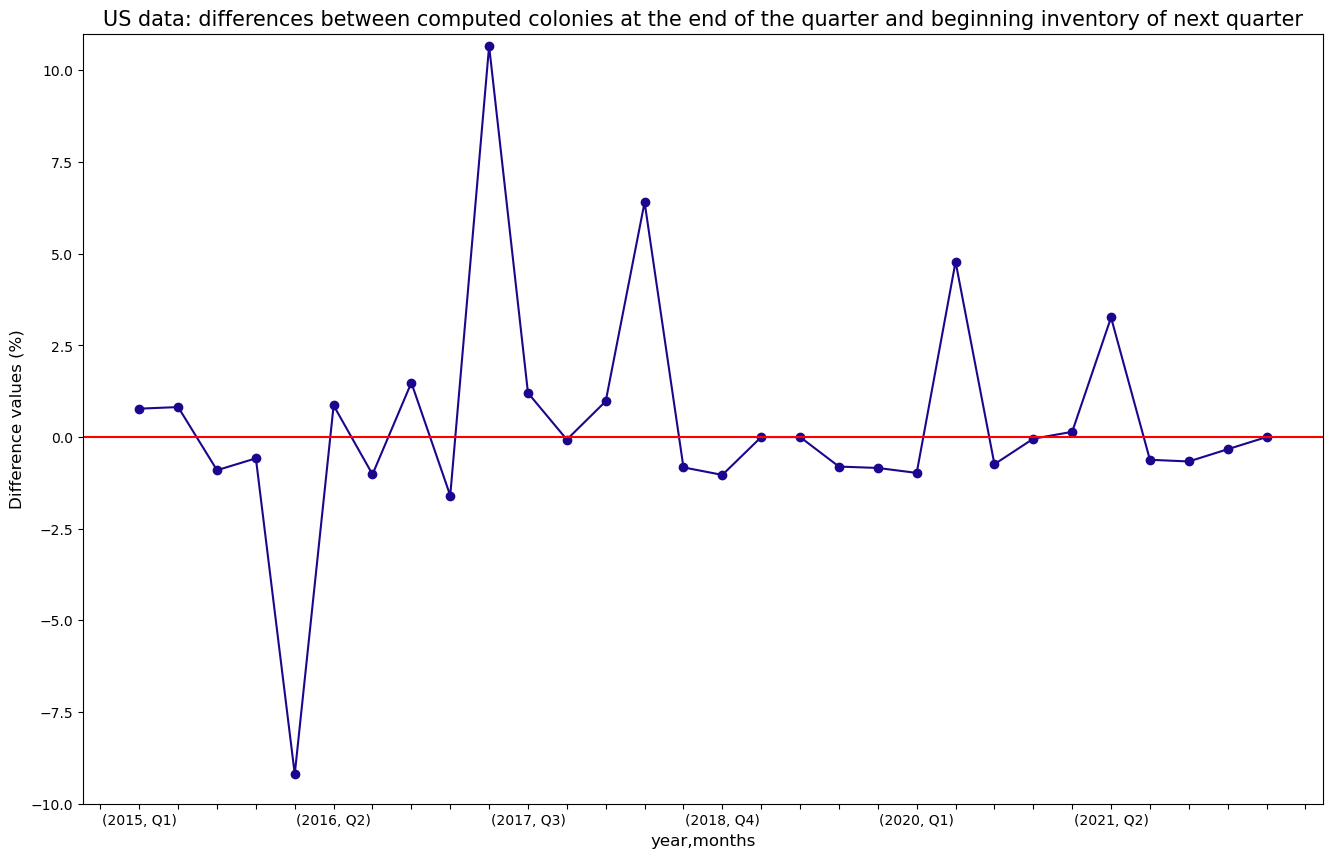

In [20]:
from matplotlib.ticker import MultipleLocator 

fig, ax = plt.subplots(figsize=(16,10))
plt.title('US data: differences between computed colonies at the end of the quarter and beginning inventory of next quarter', fontdict={'fontsize': 15})
plt.ylabel('Difference values (%)')
df_US2.groupby(["year", "months"]).sum()["diff_without_reno_pct"].plot(ax=ax, marker="o",color=custom_states)
plt.axhline(y=0, color='r', linestyle='-')
plt.ylim([-10,+11])
ax.xaxis.set_major_locator(MultipleLocator(1))
#plt.xticks(df_US3.groupby(["year", "months"]).sum().index.tolist())
plt.savefig('USdifferences_wrong.jpg')

plt.show()

The interpretation and connection through features that was explained above cannot retrieve in these US data since there are relevant difference around +/- 10%, while we would expect at most a +/- 2% due to the inaccuracy of bee keepers while filling the surveys where the data were extracted from.

## Understand the computation of n colonies along the quarters for each state

In [22]:
#all the datapoints in 2019-Q2 are missing --> the respected rows are removed
df_years.dropna(axis=0, how="all", inplace=True)
# Fill missing values for colony-related features (not stressors)
df_years[["colony_added", "colony_reno"]] = df_years[["colony_added", "colony_reno"]].fillna(value = 0, inplace=False)


#Note: to get the indices of NaN values for a given column:
#df_years[df_years['name_column'].isnull()].index.tolist()

In [23]:
#at time t: n_colony(t) = max_colony(t-1)+colony_added(t-1)- colony_lost(t-1)

#df_states = df_years.reorder_levels(["state", "year", "months"]).sort_index()
df_states = df_years.reset_index().groupby(["state", "year", "months"]).sum()
df_states.head(50)

df_states["colony_end"] = df_states["colony_n"].shift(-1) #number of colonies at the beginning of next trimester
#number of colonies we would expect to have at the end of the trimester:
df_states["colony_end_computed"] = df_states["colony_max"] + df_states["colony_added"] - df_states["colony_lost"]
df_states["differences"] = df_states["colony_end_computed"] - df_states["colony_end"] #differences between expected
#number of colonies and real number at the end of the trimester
df_states["problem_check"] = df_states["differences"] + df_states["colony_reno"]

#the differences which is encoded in "differences" are critical when they are < 0. Indeed, if our data knowledge is
#correct, we would expect to have "colony_end_computed" > "colony_end" since there are no information of the colonies
#that left the state during the trimester.
#If this is not the case (i.e. "differences" < 0), it means that there are some issues in our understanding
#of datapoints and how we are trying to link them along the trimesters.
pd.Series(df_states["differences"] < 0).value_counts()
#df_states.head(50)

#Note that "differences" does not account for "colony_repo" (as if these were not colony added during the trimester),
#while "problem_check" accounts for "colony_repo"

False    922
True     412
Name: differences, dtype: int64

In [24]:
#df_states.index.values
#print(df_states.loc[("Alabama", 2019, ["Q1", "Q3", "Q4"]), :])

#Let's set "differences" and "problem_check" equal to 0 in 2019-Q1 since the values for 2019-Q2 are missing so
#these two features cannot be properly computed
df_states.loc[(slice(None), 2019, "Q1"),["differences", "problem_check"]] = 0

#Let's also set "differences" and "problem_check" equal to 0 in 2022-Q2 since these values compare
#"colony_end_computed" with "colony_end" at 2015-Q1 of another state --> this does not have sense
df_states.loc[(slice(None), 2022, "Q2"),["differences", "problem_check"]] = 0

In [25]:
#Let's check when "problem_check" has negative values
df_states[df_states.problem_check < 0]

colony_n  colony_max  colony_lost  \
state          year months                                      
Alabama        2016 Q1        7500.0      7500.0       1700.0   
                    Q4        7000.0      7000.0        610.0   
Arizona        2020 Q1       29000.0     32000.0       6500.0   
               2021 Q1       29000.0     29000.0       7000.0   
               2022 Q1       25000.0     28000.0       2300.0   
Arkansas       2015 Q3       23000.0     30000.0       9000.0   
                    Q4       23000.0     27000.0       2400.0   
               2017 Q2       17000.0     17000.0       1900.0   
                    Q4       25000.0     25000.0       7500.0   
               2018 Q2       11500.0     11500.0       1500.0   
                    Q4       30000.0     31000.0       6000.0   
Colorado       2015 Q1        3500.0     12500.0       1500.0   
               2016 Q1        6000.0      7000.0        570.0   
               2021 Q1        3000.0     16500.0        640.0   
               2022 Q1        3800.0      8500.0        540.0   
Connecticut    2016 Q2        2500.0      2500.0        100.0   
                    Q4        3100.0      3100.0        240.0   
               2017 Q1        3100.0      3100.0        380.0   
                    Q3        3500.0      3500.0        130.0   
               2018 Q1        2900.0      2900.0        140.0   
                    Q3        3200.0      3200.0        130.0   
               2020 Q1        3700.0      4100.0        330.0   
                    Q4        4300.0      4600.0        500.0   
Georgia        2016 Q4       96000.0    112000.0      11000.0   
               2017 Q4      125000.0    145000.0      21000.0   
Hawaii         2017 Q2       12000.0     12000.0         60.0   
                    Q3       15000.0     15000.0       1100.0   
               2020 Q2       15500.0     15500.0         40.0   
Illinois       2015 Q1        6000.0     10500.0       4200.0   
               2016 Q1        7000.0      7500.0       1300.0   
                    Q2        9000.0      9000.0        740.0   
                    Q4        9000.0      9000.0        720.0   
               2017 Q1       11000.0     11000.0       2900.0   
               2018 Q1       10500.0     10500.0       2400.0   
                    Q3       11000.0     11000.0        660.0   
               2020 Q1       11500.0     13000.0       2100.0   
Indiana        2016 Q4        7500.0      7500.0       1200.0   
               2017 Q1        7000.0      7500.0       1900.0   
               2018 Q1        7000.0      8000.0       1000.0   
               2021 Q1       10000.0     11000.0       2700.0   
Iowa           2018 Q1       41000.0     45000.0       1300.0   
               2021 Q3       37000.0     54000.0       4500.0   
               2022 Q1       26000.0     29000.0       2800.0   
Kansas         2015 Q1        4600.0      7000.0       1600.0   
               2016 Q1        4700.0      4700.0        980.0   
               2017 Q1        3800.0      3800.0       1000.0   
               2018 Q1        3700.0      3700.0        950.0   
               2021 Q1        5000.0      6500.0       1400.0   
Kentucky       2015 Q1        7500.0     10500.0       4100.0   
               2018 Q1        5500.0      5500.0       1600.0   
               2020 Q1        7000.0     10500.0       1200.0   
               2021 Q1        9500.0      9500.0       2100.0   
Louisiana      2019 Q4       41000.0     46000.0       2300.0   
               2020 Q4       46000.0     52000.0       1700.0   
Maine          2016 Q1        2200.0      3700.0        170.0   
               2018 Q1        1900.0      1900.0        240.0   
                    Q3       12500.0     12500.0        890.0   
               2020 Q1        1300.0      1700.0        130.0   
Maryland       2016 Q1        6500.0      6500.0       1400.0   
                    Q3        7000.0      7000.0        200.0  

(-10000.0, 10000.0)

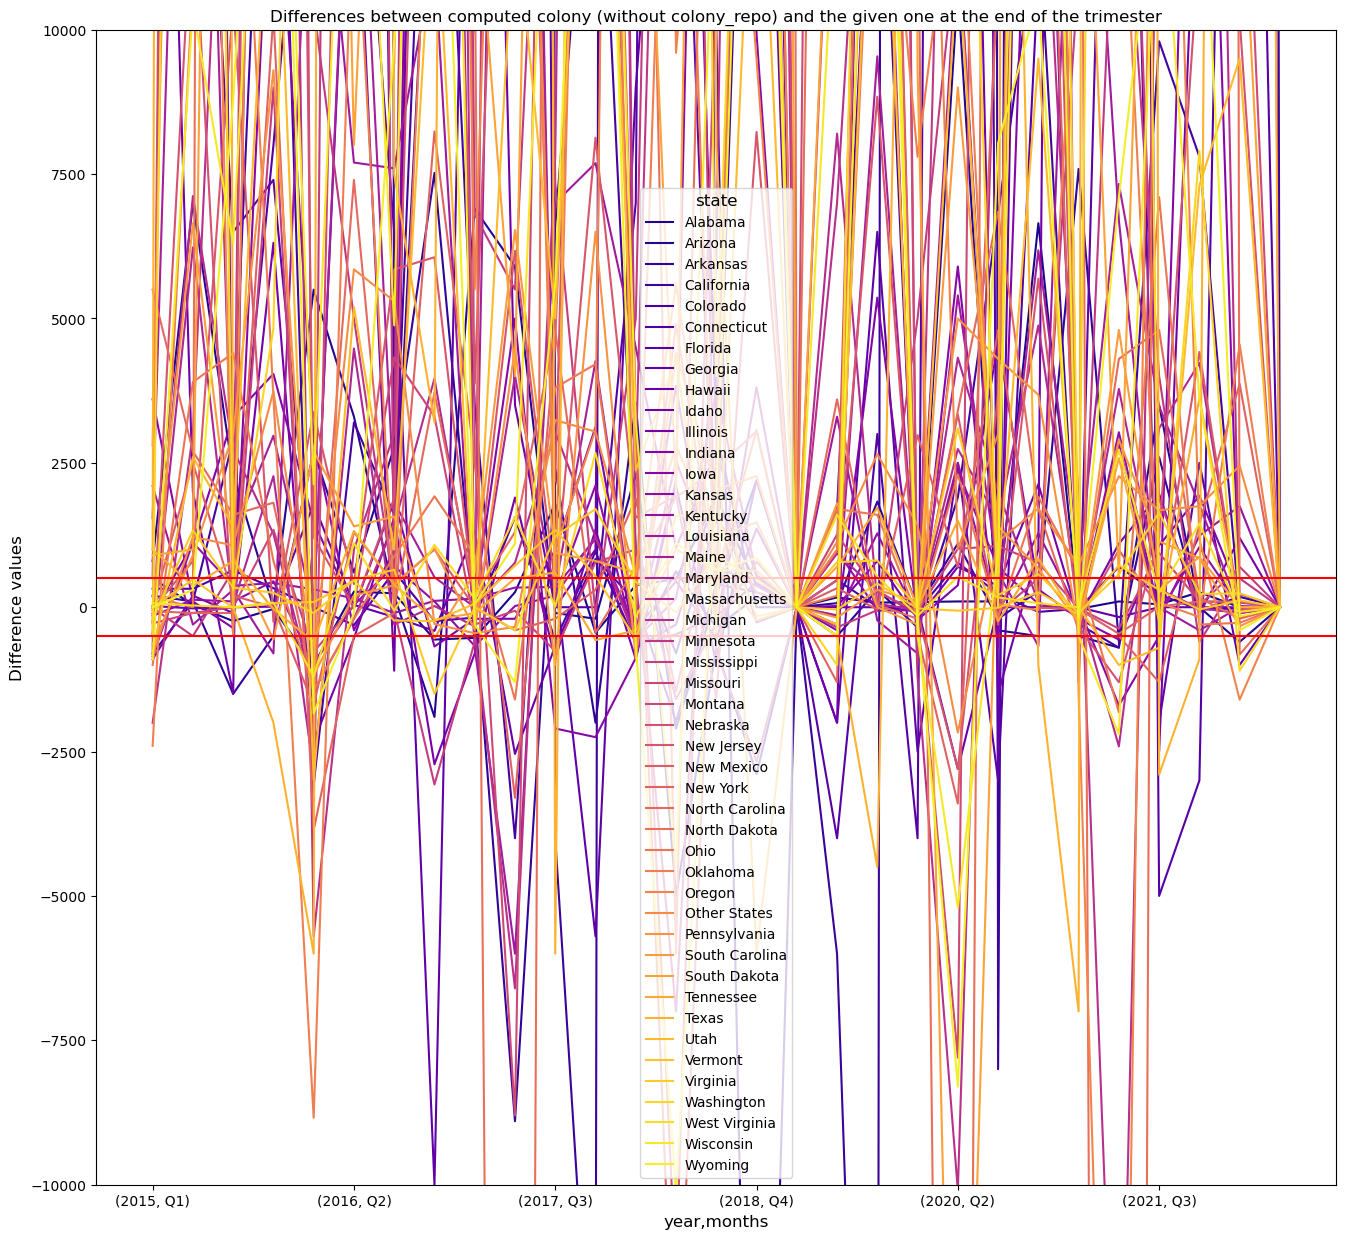

In [26]:
fig, ax = plt.subplots(figsize=(16,15))
plt.title('Differences between computed colony (without colony_repo) and the given one at the end of the trimester')
plt.ylabel('Difference values')
df_states["differences"].unstack(level=0).plot(ax=ax,color=custom_states)
#last "differences" value in time for each state (Q2 of 2022) does not hold since it is computed with respect to
#the first timestamp of the next state.
plt.axhline(y=+500, color='r', linestyle='-')
plt.axhline(y=-500, color='r', linestyle='-')
plt.ylim([-10000,+10000])

In [27]:
#Let's check in which quarters "problem_check" has negative values
df_states[df_states.differences < 0].index.get_level_values(2).value_counts().sort_index()

Q1    152
Q2     71
Q3     81
Q4     59
Name: months, dtype: int64

**Conclusion**: <br>
Either our understanding of datapoints is not correct, or the values reported are not accurate since we cannot explain the link between the number of colonies in the different trimesters

# USDA Dataset - Check the differences with respect to TidyTuesday Dataset

In [30]:
#new code using "cleaned_by_state.csv" preprocessed as in "main.Rmd"
#rows of dataset for 2019-Q2 already removed and NaN values substitued with 0

df_new = pd.read_csv(start_path + "/code/DataConsistency/cleaned_by_state.csv")
print(df_new.Period.unique())
map_quarters2 = {
    'JAN THRU MAR': "Q1",
    'APR THRU JUN': "Q2",
    'JUL THRU SEP': "Q3",
    'OCT THRU DEC': "Q4"
}
df_new['Period'] = df_new['Period'].map(map_quarters2)
df_new.State = df_new.State.apply(lambda x: x.lower())
df_new.rename(columns = {"Year": "year", "Period": "months", "State": "state"}, inplace=True)
df_new = df_new.set_index(['year', 'months', 'state'])
df_new.sort_index(inplace=True)
df_new.head()

['APR THRU JUN' 'JAN THRU MAR' 'JUL THRU SEP' 'OCT THRU DEC']


State ANSI  \
year months state                   
2015 Q1     alabama            01   
            arizona            04   
            arkansas           05   
            california         06   
            colorado           08   

                        HONEY, BEE COLONIES - ADDED & REPLACED, MEASURED IN COLONIES  \
year months state                                                                      
2015 Q1     alabama                                                  2800              
            arizona                                                  3400              
            arkansas                                                 1200              
            california                                             250000              
            colorado                                                  200              

                        HONEY, BEE COLONIES - INVENTORY, MAX, MEASURED IN COLONIES  \
year months state                                                                    
2015 Q1     alabama                                                7000.0            
            arizona                                               35000.0            
            arkansas                                              14000.0            
            california                                          1690000.0            
            colorado                                              12500.0            

                        HONEY, BEE COLONIES - LOSS, COLONY COLLAPSE DISORDER, MEASURED IN COLONIES  \
year months state                                                                                    
2015 Q1     alabama                                                     0                            
            arizona                                                     0                            
            arkansas                                                    0                            
            california                                                  0                            
            colorado                                                    0                            

                        HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED IN COLONIES  \
year months state                                                                   
2015 Q1     alabama                                                1800.0           
            arizona                                                4600.0           
            arkansas                                               1500.0           
            california                                           255000.0           
            colorado                                               1500.0           

                        HONEY, BEE COLONIES - LOSS, DEADOUT, MEASURED IN PCT OF COLONIES  \
year months state                                                                          
2015 Q1     alabama                                                    26                  
            arizona                                                    13                  
            arkansas                                                   11                  
            california                                                 15                  
            colorado                                                   12                  

                        HONEY, BEE COLONIES, AFFECTED BY DISEASE - INVENTORY, MEASURED IN PCT OF COLONIES  \
year months state                                                                                           
2015 Q1     alabama                                                   0.0                                   
            arizona                                                   0.1                                   
            arkansas                                                  1.5                                   
            california                    

In [31]:
#df_years.columns

df_new.drop(df_new.columns[[0, 3]], axis=1, inplace=True)
df_new.columns = ['colony_added', 'colony_max', 'colony_lost', 'colony_lost_pct', 'Disesases', 'Other', 'Pesticides', 'Other pests/parasites', 'Unknown', 'Varroa mites', 'colony_reno', 'colony_reno_pct', 'colony_n']
df_new = df_new[df_years.columns] #reorder the columns of df_new to match the ones of df_years
df_new.head()

colony_n  colony_max  colony_lost  colony_lost_pct  \
year months state                                                             
2015 Q1     alabama        7000.0      7000.0       1800.0               26   
            arizona       35000.0     35000.0       4600.0               13   
            arkansas      13000.0     14000.0       1500.0               11   
            california  1440000.0   1690000.0     255000.0               15   
            colorado       3500.0     12500.0       1500.0               12   

                        colony_added  colony_reno  colony_reno_pct  Disesases  \
year months state                                                               
2015 Q1     alabama             2800        250.0                4        0.0   
            arizona             3400       2100.0                6        0.1   
            arkansas            1200         90.0                1        1.5   
            california        250000     124000.0                7        3.0   
            colorado             200        140.0                1        1.8   

                        Other  Other pests/parasites  Pesticides  Unknown  \
year months state                                                           
2015 Q1     alabama       9.1                    5.4         2.2      9.4   
            arizona       1.8                   20.5         0.0      3.1   
            arkansas      1.0                   11.4         3.4      1.0   
            california    6.5                    7.2         7.5      2.8   
            colorado      2.6                    0.9         0.6      5.9   

                        Varroa mites  
year months state                     
2015 Q1     alabama             10.0  
            arizona             26.9  
            arkansas            17.6  
            california          24.7  
            colorado            14.6

In [32]:
df_new.isna().sum()

colony_n                 0
colony_max               0
colony_lost              0
colony_lost_pct          0
colony_added             0
colony_reno              0
colony_reno_pct          0
Disesases                0
Other                    0
Other pests/parasites    0
Pesticides               0
Unknown                  0
Varroa mites             0
dtype: int64

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1334 entries, (2015, 'Q1', 'alabama') to (2022, 'Q2', 'wyoming')
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   colony_n               1334 non-null   float64
 1   colony_max             1334 non-null   float64
 2   colony_lost            1334 non-null   float64
 3   colony_lost_pct        1334 non-null   int64  
 4   colony_added           1334 non-null   int64  
 5   colony_reno            1334 non-null   float64
 6   colony_reno_pct        1334 non-null   int64  
 7   Disesases              1334 non-null   float64
 8   Other                  1334 non-null   float64
 9   Other pests/parasites  1334 non-null   float64
 10  Pesticides             1334 non-null   float64
 11  Unknown                1334 non-null   float64
 12  Varroa mites           1334 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 141.5+ KB


In [34]:
df_years_new = df_years.fillna(value=0, inplace=False) #Fill NaN also for stressor features of df_years
df_years_new.isna().sum()

colony_n                 0
colony_max               0
colony_lost              0
colony_lost_pct          0
colony_added             0
colony_reno              0
colony_reno_pct          0
Disesases                0
Other                    0
Other pests/parasites    0
Pesticides               0
Unknown                  0
Varroa mites             0
dtype: int64

In [35]:
#name of the state as lowercase in df_years_new to match the names of df_new:
df_years_new = df_years_new.reset_index()
df_years_new.state = df_years_new.state.apply(lambda x: x.lower())
df_years_new = df_years_new.set_index(['year', 'months', 'state'])

In [36]:
len(df_new.index.levels[2].tolist()) == len(df_years_new.index.levels[2].tolist())
df_new.index.levels[2]
# --> No overall United States values here

Index(['alabama', 'arizona', 'arkansas', 'california', 'colorado',
       'connecticut', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois',
       'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine',
       'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi',
       'missouri', 'montana', 'nebraska', 'new jersey', 'new mexico',
       'new york', 'north carolina', 'north dakota', 'ohio', 'oklahoma',
       'oregon', 'other states', 'pennsylvania', 'south carolina',
       'south dakota', 'tennessee', 'texas', 'utah', 'vermont', 'virginia',
       'washington', 'west virginia', 'wisconsin', 'wyoming'],
      dtype='object', name='state')

In [37]:
#df_new.describe()
#df_years.describe()

#differences between the two dataframes:
df_diff = df_new - df_years_new
#print the rows where at least one value is different from zero:
print(df_diff[(df_diff != 0).any(axis=1)].shape)
df_diff[(df_diff != 0).any(axis=1)] #df_diff[df_diff.values != 0]

(343, 13)


colony_n  colony_max  colony_lost  \
year months state                                               
2016 Q1     alabama              0.0         0.0          0.0   
            arizona              0.0         0.0          0.0   
            arkansas             0.0         0.0          0.0   
            california      -10000.0         0.0     -10000.0   
            colorado         -1000.0      1500.0        180.0   
            florida          30000.0     30000.0      -5000.0   
            georgia              0.0         0.0      -4500.0   
            hawaii               0.0         0.0          0.0   
            idaho             1000.0      1000.0       2000.0   
            illinois          1500.0      2000.0        100.0   
            indiana              0.0         0.0          0.0   
            iowa             -3500.0     -3500.0       -300.0   
            kansas             300.0       300.0        120.0   
            kentucky          -500.0      -500.0          0.0   
            louisiana       -14000.0    -14000.0       1500.0   
            maryland          1000.0      1000.0       -580.0   
            massachusetts        0.0         0.0          0.0   
            michigan             0.0      5000.0          0.0   
            minnesota        -1000.0     -1000.0       -500.0   
            mississippi      -3000.0    -27000.0       1000.0   
            missouri         -1500.0     -1500.0        100.0   
            montana           1000.0     17000.0         60.0   
            nebraska           500.0     -1000.0        390.0   
            new jersey       -2500.0     -2500.0          0.0   
            new mexico           0.0         0.0          0.0   
            new york             0.0      2000.0        200.0   
            north carolina       0.0         0.0        100.0   
            north dakota      7000.0    -36000.0      -8500.0   
            ohio               500.0       500.0      -1300.0   
            oklahoma          7500.0      7500.0        400.0   
            oregon           -2000.0         0.0        100.0   
            other states        50.0        50.0          0.0   
            pennsylvania         0.0         0.0          0.0   
            south carolina       0.0         0.0        100.0   
            south dakota     17000.0    -12000.0       9730.0   
            tennessee            0.0         0.0          0.0   
            texas                0.0     30000.0       1000.0   
            utah                 0.0      2000.0        200.0   
            vermont              0.0         0.0          0.0   
            virginia             0.0         0.0          0.0   
            washington       -1000.0     11000.0        500.0   
            west virginia        0.0       500.0          0.0   
            wisconsin        -2000.0     -2000.0        200.0   
            wyoming              0.0      1500.0          0.0   
     Q2     vermont              0.0         0.0          0.0   
2017 Q1     alabama              0.0         0.0          0.0   
            arizona              0.0         0.0          0.0   
            arkansas             0.0         0.0          0.0   
            california       20000.0     30000.0      23000.0   
            florida              0.0         0.0          0.0   
            georgia              0.0         0.0          0.0   
            illinois             0.0         0.0          0.0   
            kansas               0.0         0.0          0.0   
            louisiana            0.0         0.0          0.0   
            massachusetts        0.0         0.0          0.0   
            minnesota            0.0         0.0          0.0   
            mississippi          0.0         0.0          0.0   
            missouri           500.0         0.0          0.0   
            montana              0.0         0.0          0.0   
            nebraska             0.0         0.0          0.0  

In [ ]:
'''
Old code

print(df_new.index.shape)
print(df_years_new.index.shape)
#check differences between indices
list_indices1 = df_new.index.tolist()
list_indices2 = df_years_new.index.tolist()
diff_list = sorted(list(set(list_indices2) - set(list_indices1)))# key=lambda tup: tup[1])
print(diff_list)
df_years_new = df_years_new.drop(diff_list)

df_new = df_new.applymap(lambda x: x.replace(",",""))
df_new = df_new.applymap(lambda x: x.replace("(Z)","0"))
df_new = df_new.applymap(lambda x: x.replace("-","0"))
df_new = df_new.fillna(0)
df_years_new = df_years_new.fillna(0)

df_new = df_new.astype("int")
df_years_new = df_years_new.astype("int")
df_diff = df_new - df_years_new
df_diff.mean(),df_diff.std()
'''

**Let's check that the differences between the values of the two datasets were not due to some values that were set to zero in one dataframe and not in the other one**

In [38]:
indices = df_diff[df_diff.values != 0].index
df_new_subset = df_new.loc[indices,:]
print(df_new_subset[df_new_subset == 0].count(axis=0)/len(df.index))

colony_n                 0.000000
colony_max               0.000000
colony_lost              0.001449
colony_lost_pct          0.006522
colony_added             0.005797
colony_reno              0.107246
colony_reno_pct          0.231884
Disesases                0.318116
Other                    0.071014
Other pests/parasites    0.121014
Pesticides               0.309420
Unknown                  0.175362
Varroa mites             0.006522
dtype: float64


In [39]:
df_years_new_subset = df_new.loc[indices,:]
print(df_years_new_subset[df_years_new_subset == 0].count(axis=0)/len(df.index))

colony_n                 0.000000
colony_max               0.000000
colony_lost              0.001449
colony_lost_pct          0.006522
colony_added             0.005797
colony_reno              0.107246
colony_reno_pct          0.231884
Disesases                0.318116
Other                    0.071014
Other pests/parasites    0.121014
Pesticides               0.309420
Unknown                  0.175362
Varroa mites             0.006522
dtype: float64


In [40]:
#this loop prints the values of df_years_new for each column where df_new in that column is equal to zero.
#If the corresponding values in df_years_new are not equal to zero, means that there are cases where df_new had
#NaN values (then set to zero) while df_years_new did not have.
indices_new = indices.unique()
for col in df_new.columns:
    print(df_years_new.loc[indices_new,col][(df_new.loc[indices_new, col] == 0).values]) #"{}: ".format(col)

#vice versa:
'''
for col in df_new.columns:
    print(df_new.loc[indices_new,col][(df_years_new.loc[indices_new, col] == 0).values]) #"{}: ".format(col)
'''

Series([], Name: colony_n, dtype: float64)
Series([], Name: colony_max, dtype: float64)
year  months  state 
2020  Q2      hawaii    40.0
Name: colony_lost, dtype: float64
year  months  state       
2016  Q2      vermont         0.0
2020  Q1      montana         0.0
      Q2      hawaii          0.0
2021  Q1      north dakota    0.0
Name: colony_lost_pct, dtype: float64
year  months  state        
2016  Q1      vermont             0.0
              west virginia       0.0
2017  Q1      vermont             0.0
2020  Q1      north dakota     2500.0
Name: colony_added, dtype: float64
year  months  state        
2016  Q1      indiana           0.0
              iowa              0.0
              minnesota        10.0
              montana           0.0
              nebraska         30.0
              north dakota      0.0
              other states     10.0
              south dakota      0.0
              vermont           0.0
              west virginia    10.0
              wisconsin 

'\nfor col in df_new.columns:\n    print(df_new.loc[indices_new,col][(df_years_new.loc[indices_new, col] == 0).values]) #"{}: ".format(col)\n'

In [41]:
print(df_new.loc[(2020, "Q2", "hawaii"), "colony_lost"])
print(df_years_new.loc[(2020, "Q2", "hawaii"), "colony_lost"])

0.0
40.0


**Conclusion**: In both the dataframes there are values which are equal to zero in one but not in the other one. <br>
This might represent an issue since each dataframe had different NaN values with respect to the other one which were then set to zero. <br>
**Problem**: I can't check the indices of NaN values for df_new dataframe since it was preprocessed removing the NaN values before importing it.

## Check the datapoint correctness and coherency in USDA dataset

**Reference**: <br>
The questionnaire can be viewed here: https://www.nass.usda.gov/Publications/Methodology_and_Data_Quality/Honey_Bee_Colonies/08_2022/July%202022%20QCL.pdf <br>
That is a link to the questionnaire for the July quarter. Similar questionnaires are used in October and then the following January and April, with the only difference being the year and month used in the questions.
 
Max colonies is calculated in the summary. While some colonies in the U.S. are primarily honey producing colonies and usually remain in one state, other colonies are primarily used for pollination purposes. Pollinating colonies are moved from state to state throughout the year following the crops that need to be pollinated. Therefore, the maximum number of colonies in a state can vary widely during a quarter and throughout the year. For example, on an individual record level an operation could not have any colonies in North Dakota at the beginning of a quarter because all of their colonies are in California for almond pollination. But during the middle of the quarter the almond pollination season ends and the colonies are moved back to North Dakota. So while the January 1 colony number might be zero, the max colony number during the January – March quarter could be 1,000.
 
The record level data is processed in a summary which also deals with non-response through a weighting procedure and the state level indications are created.
 
Colonies renovated are not included in the calculation for the next quarter’s starting inventory.
 
As you can see on the questionnaire linked above, beginning and ending inventory is asked on the survey. Ending inventory is generally considered one of the stronger indications due to memory bias of remembering facts from three months ago and what happened during those three months.
 
At the state level the calculation is as follows: Max colonies – Lost Colonies + Added Colonies  = Beginning Inventory of next quarter, assuming no colonies were moved out of state. However, because colonies can move out of state before the start of the next quarter, it means that the starting inventory can be much lower. If no colonies are moved out of state, then the calculation above should be within 2% of the starting inventory of the following quarter. At the national level, the maximum colony value is not calculated as colonies are not sent across borders for pollinating. Therefore the calculation is First of the Quarter Inventory – Lost + Added = (+/-1%) Beginning Inventory.

## USA data

In [51]:
df_US_new = df_new[["colony_n", "colony_lost", "colony_added"]]
df_US_new["colony_n"].reset_index()
df_US_new = df_US_new.groupby(["year", "months"]).sum()

In [52]:
df_US_new.head()

colony_n  colony_lost  colony_added
year months                                      
2015 Q1      2824610.0     500020.0        546980
     Q2      2849500.0     352860.0        661860
     Q3      3132880.0     457100.0        172990
     Q4      2874760.0     412380.0        117150
2016 Q1      2619940.0     416100.0        571880

In [53]:
df_US_new["colony_end"] = df_US_new["colony_n"].shift(-1)
df_US_new["colony_end_computed"] = df_US_new["colony_n"] + df_US_new["colony_added"] - df_US_new["colony_lost"]
df_US_new["diff_without_reno"] = df_US_new["colony_end_computed"]-df_US_new["colony_end"]
df_US_new["diff_without_reno_pct"] = df_US_new["diff_without_reno"]*100/df_US_new["colony_end"]
df_US_new.loc[(2019,"Q1"), ["diff_without_reno", "diff_without_reno_pct"]] = [0,0]
df_US_new

colony_n  colony_lost  colony_added  colony_end  \
year months                                                     
2015 Q1      2824610.0     500020.0        546980   2849500.0   
     Q2      2849500.0     352860.0        661860   3132880.0   
     Q3      3132880.0     457100.0        172990   2874760.0   
     Q4      2874760.0     412380.0        117150   2619940.0   
2016 Q1      2619940.0     416100.0        571880   2801470.0   
     Q2      2801470.0     329820.0        736920   3181180.0   
     Q3      3181180.0     397290.0        217320   3032060.0   
     Q4      3032060.0     502350.0        124660   2641090.0   
2017 Q1      2641090.0     398650.0        478240   2694150.0   
     Q2      2694150.0     285590.0        613360   2994500.0   
     Q3      2994500.0     394810.0        284370   2849770.0   
     Q4      2849770.0     424860.0        204510   2635220.0   
2018 Q1      2635220.0     438030.0        511320   2665880.0   
     Q2      2665880.0     355270.0        676360   2958790.0   
     Q3      2958790.0     377120.0        263560   2868970.0   
     Q4      2868970.0     444730.0        219640   2671470.0   
2019 Q1      2671470.0     407700.0        247710   3175960.0   
     Q3      3175960.0     434700.0        252550   3018110.0   
     Q4      3018110.0     399510.0        233260   2876100.0   
2020 Q1      2876100.0     415110.0        511160   2972000.0   
     Q2      2972000.0     300990.0        536170   3175330.0   
     Q3      3175330.0     411490.0        348280   3135340.0   
     Q4      3135340.0     484920.0        271500   2903240.0   
2021 Q1      2903240.0     464640.0        417490   2829520.0   
     Q2      2829520.0     352280.0        665730   3173390.0   
     Q3      3173390.0     295660.0        194900   3091790.0   
     Q4      3091790.0     329110.0         93940   2875770.0   
2022 Q1      2875770.0     331780.0        367890   2921590.0   
     Q2      2921590.0     282630.0        589630         NaN   

             colony_end_computed  diff_without_reno  diff_without_reno_pct  
year months                                                                 
2015 Q1                2871570.0            22070.0               0.774522  
     Q2                3158500.0            25620.0               0.817778  
     Q3                2848770.0           -25990.0              -0.904075  
     Q4                2579530.0           -40410.0              -1.542402  
2016 Q1                2775720.0           -25750.0              -0.919160  
     Q2                3208570.0            27390.0               0.861001  
     Q3                3001210.0           -30850.0              -1.017460  
     Q4                2654370.0            13280.0               0.502823  
2017 Q1                2720680.0            26530.0               0.984726  
     Q2                3021920.0            27420.0               0.915679  
     Q3                2884060.0            34290.0               1.203255  
     Q4                2629420.0            -5800.0              -0.220095  
2018 Q1                2708510.0            42630.0               1.599097  
     Q2                2986970.0            28180.0               0.952416  
     Q3                2845230.0           -23740.0              -0.827475  
     Q4                2643880.0           -27590.0              -1.032765  
2019 Q1                2511480.0                0.0               0.000000  
     Q3                2993810.0           -24300.0              -0.805140  
     Q4                2851860.0           -24240.0              -0.842808  
2020 Q1                2972150.0              150.0               0.005047  
     Q2                3207180.0            31850.0               1.003045  
     Q3                3112120.0           -23220.0              -0.740590  
     Q4                2921920.0            18680.0               0.643419  
2021 Q1                2856090.0            26570.0               0.93902

(-10.0, 11.0)

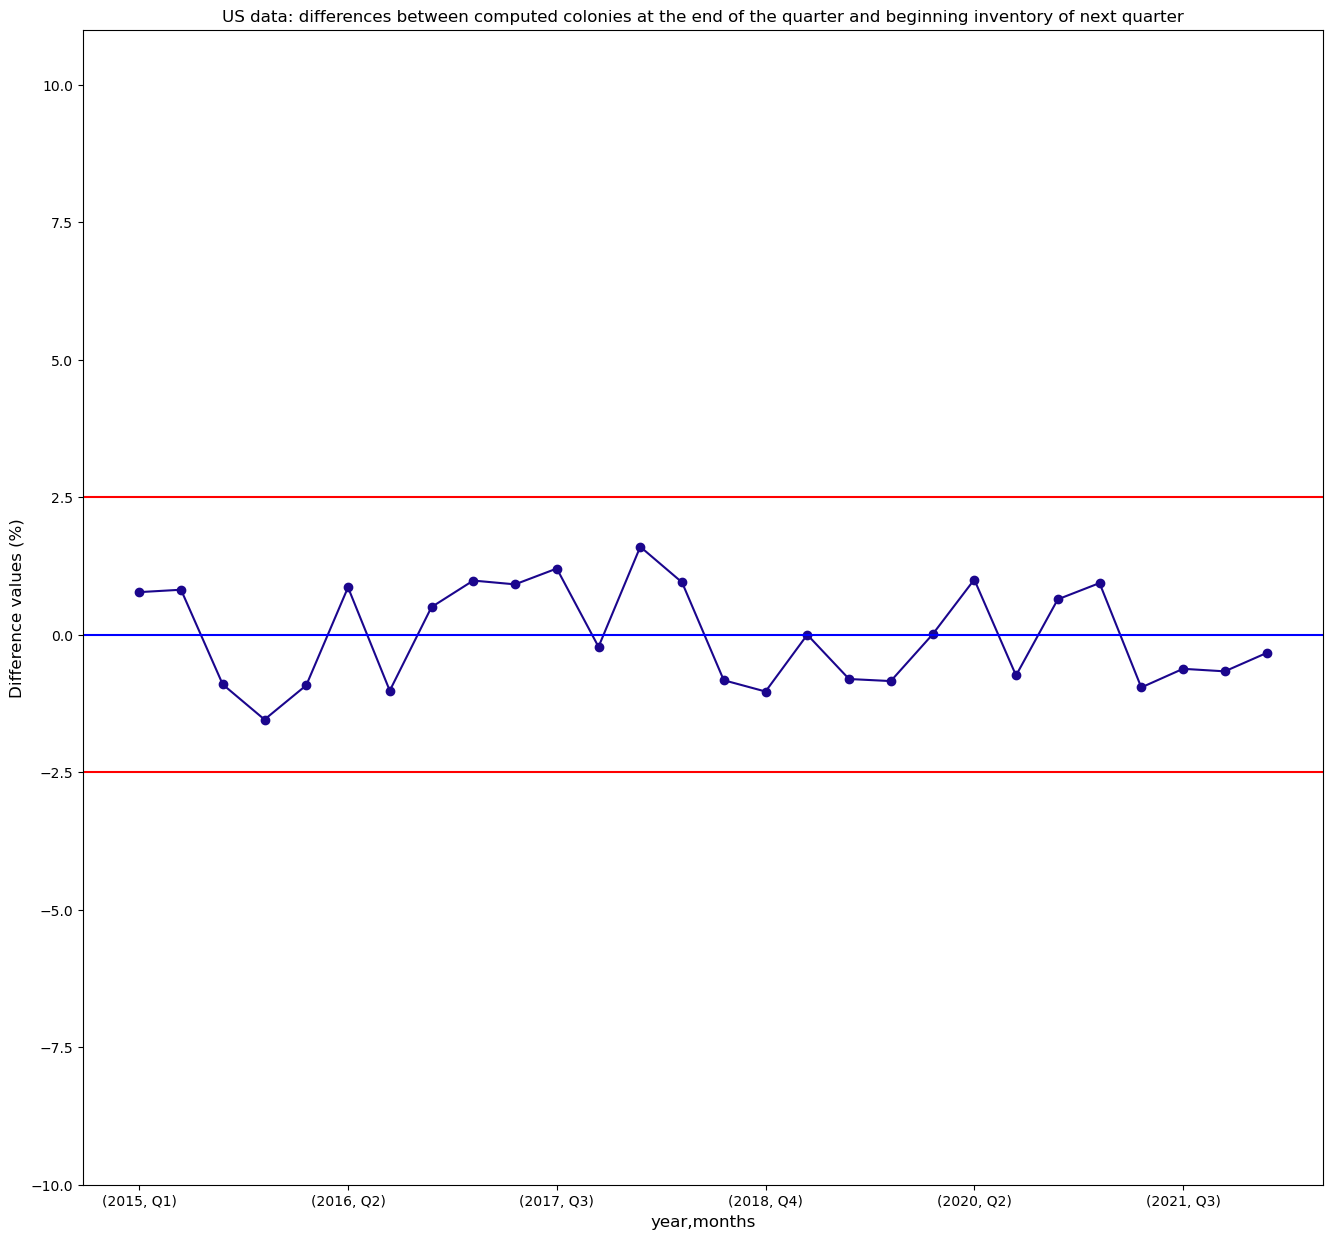

In [54]:
fig, ax = plt.subplots(figsize=(16,15))
plt.title('US data: differences between computed colonies at the end of the quarter and beginning inventory of next quarter')
plt.ylabel('Difference values (%)')
df_US_new["diff_without_reno_pct"].plot(ax=ax, marker="o",color=custom_states)
plt.axhline(y=0, color='b', linestyle='-')
plt.axhline(y=2.5, color='r', linestyle='-')
plt.axhline(y=-2.5, color='r', linestyle='-')
plt.ylim([-10,+11])

**!!!!   Coherent results for US    !!!!!** <br>

## For each State:

In [55]:
df_new.head()

colony_n  colony_max  colony_lost  colony_lost_pct  \
year months state                                                             
2015 Q1     alabama        7000.0      7000.0       1800.0               26   
            arizona       35000.0     35000.0       4600.0               13   
            arkansas      13000.0     14000.0       1500.0               11   
            california  1440000.0   1690000.0     255000.0               15   
            colorado       3500.0     12500.0       1500.0               12   

                        colony_added  colony_reno  colony_reno_pct  Disesases  \
year months state                                                               
2015 Q1     alabama             2800        250.0                4        0.0   
            arizona             3400       2100.0                6        0.1   
            arkansas            1200         90.0                1        1.5   
            california        250000     124000.0                7        3.0   
            colorado             200        140.0                1        1.8   

                        Other  Other pests/parasites  Pesticides  Unknown  \
year months state                                                           
2015 Q1     alabama       9.1                    5.4         2.2      9.4   
            arizona       1.8                   20.5         0.0      3.1   
            arkansas      1.0                   11.4         3.4      1.0   
            california    6.5                    7.2         7.5      2.8   
            colorado      2.6                    0.9         0.6      5.9   

                        Varroa mites  
year months state                     
2015 Q1     alabama             10.0  
            arizona             26.9  
            arkansas            17.6  
            california          24.7  
            colorado            14.6

In [56]:
#at time t: n_colony(t) = max_colony(t-1)+colony_added(t-1)- colony_lost(t-1)

df_new_states = df_new.reset_index().groupby(["state", "year", "months"]).sum()
df_new_states["colony_end"] = df_new_states["colony_n"].shift(-1) #number of colonies at the beginning of next trimester
#number of colonies we would expect to have at the end of the trimester:
df_new_states["colony_end_computed"] = df_new_states["colony_max"] + df_new_states["colony_added"] - df_new_states["colony_lost"]
df_new_states["diff"] = df_new_states["colony_end_computed"] - df_new_states["colony_end"] #differences between expected
#number of colonies and real number at the end of the trimester
df_new_states["diff_pct"] = df_new_states["diff"]*100/df_new_states["colony_max"]


#Let's set "differences" and "problem_check" equal to 0 in 2019-Q1 since the values for 2019-Q2 are missing so
#these two features cannot be properly computed
df_new_states.loc[(slice(None), 2019, "Q1"),["diff", "diff_pct"]] = 0

#Let's also set "differences" and "problem_check" equal to 0 in 2022-Q2 since these values compare
#"colony_end_computed" with "colony_end" at 2015-Q1 of another state --> this does not have sense
df_new_states.loc[(slice(None), 2022, "Q2"),["diff", "diff_pct"]] = 0

#the differences which is encoded in "diff_pct" are critical when they are < 0. Indeed, if our data knowledge is
#correct, we would expect to have "colony_end_computed" > "colony_end" since there are no information of the colonies
#that left the state during the trimester.
#If this is not the case (i.e. "diff_pct" < 0), it means that there are some issues in our understanding
#of datapoints and how we are trying to link them along the trimesters.
pd.Series(df_new_states["diff_pct"] < 0).value_counts()
#df_states.head(50)

#Note that "diff" and "diff_pct" do not account for "colony_repo" (as if these were not colony added during the trimester),

False    1006
True      328
Name: diff_pct, dtype: int64

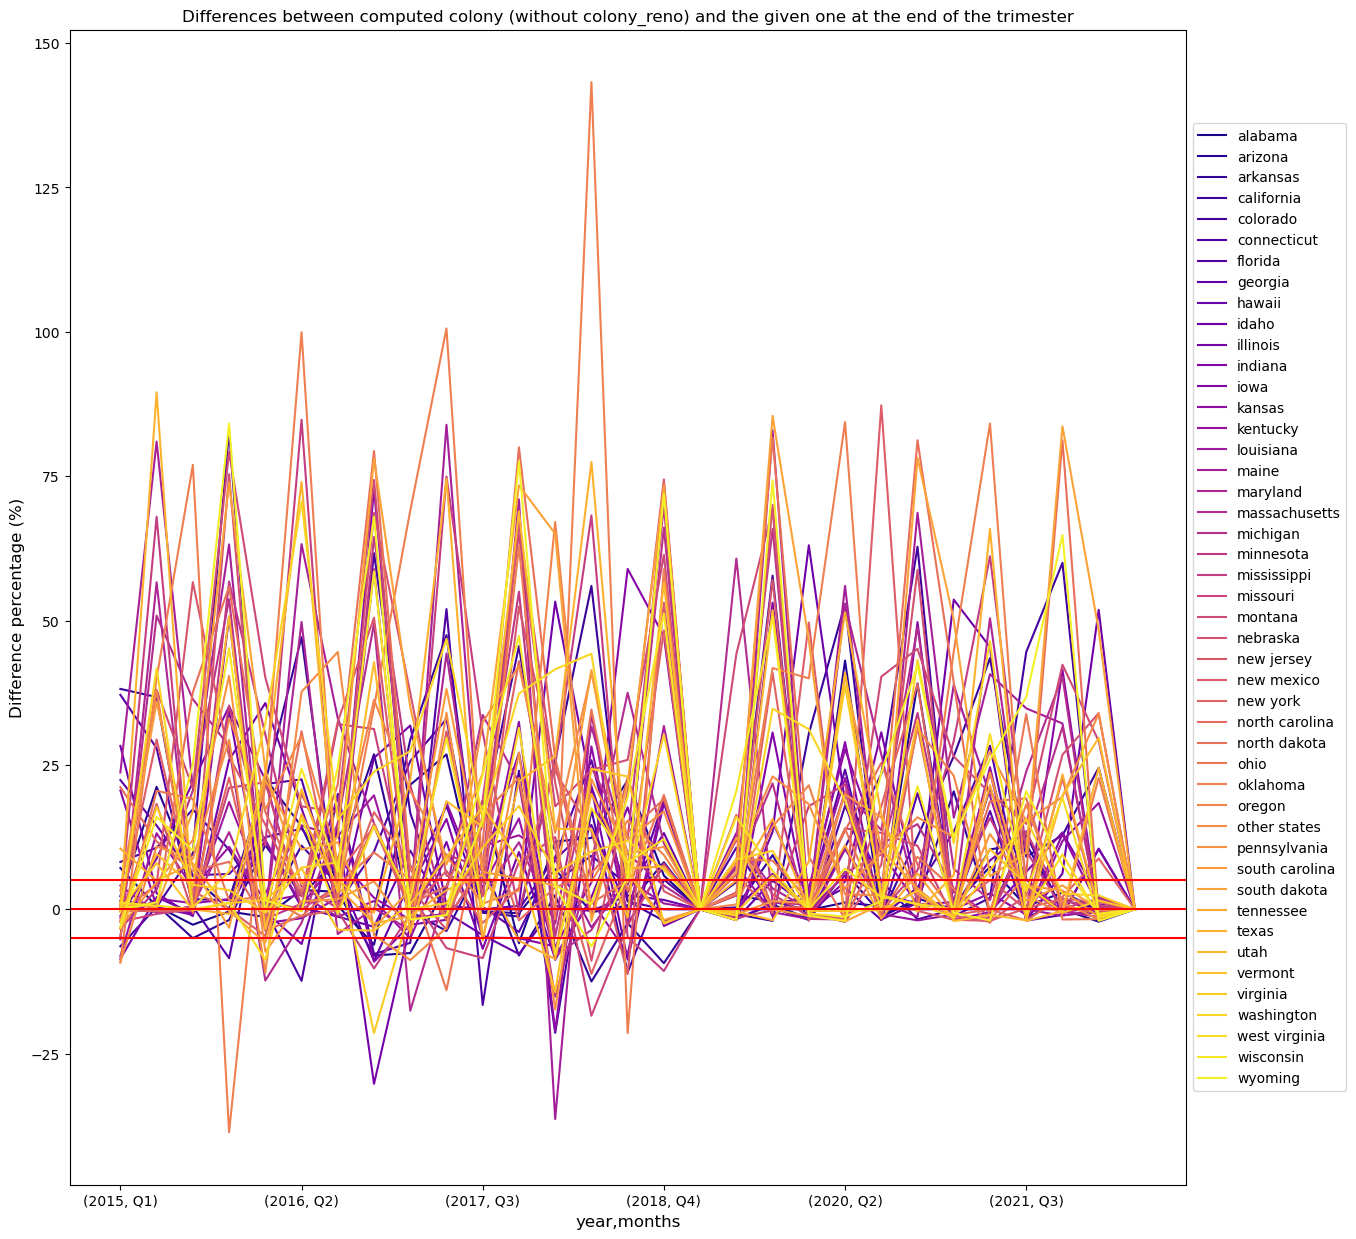

In [57]:
fig, ax = plt.subplots(figsize=(16,15))
plt.title('Differences between computed colony (without colony_reno) and the given one at the end of the trimester')
plt.ylabel('Difference percentage (%)')
df_new_states["diff_pct"].unstack(level=0).plot(ax=ax,color=custom_states)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=5, color='r', linestyle='-')
plt.axhline(y=-5, color='r', linestyle='-')

# Shrink current axis by 10%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## WOOOOOOOWWWWW FINALLY !!!!

In [186]:
#critical states, years and quarters where the data are not that coherent
df_new_states[df_new_states["diff_pct"] < -5]["diff_pct"]
#df_new_states.loc[("connecticut", slice(None), slice(None)),:]

state          year  months
alabama        2016  Q4        -8.000000
               2017  Q1        -7.571429
                     Q4        -5.866667
arizona        2016  Q4        -6.129032
arkansas       2017  Q4        -8.000000
               2018  Q2       -12.500000
                     Q4        -9.322581
colorado       2015  Q1        -6.400000
connecticut    2016  Q2       -12.400000
                     Q4        -7.741935
               2017  Q1        -5.806452
                     Q3       -16.571429
               2018  Q1       -21.379310
                     Q3       -10.937500
florida        2015  Q4        -8.461538
georgia        2016  Q4        -8.928571
hawaii         2017  Q4        -7.733333
illinois       2015  Q1        -8.571429
               2016  Q2        -6.000000
                     Q4       -30.222222
               2017  Q3        -6.846154
               2018  Q1        -8.571429
                     Q3        -8.727273
indiana        2016  Q4      